#  <span style="color:blue">Tutorial - Time and Motion</span>

The following tutorial tasks implement concepts covered in these notes using Python:
- Representing trajectories and sampling them through interpolation
- Modelling robotic motion through rigid body and actuator kinematics
    
Classes and functions defined in this section are also contained in the course libraries `model_feeg6043.py` and `math_feeg6043.py` and `plot_feeg6043.py` libraries, where we will also use function already defined in these libraries from earlier in the course. The figure below gives an overview of what we will cover.

<img src="images/A1_2_Tutorial_Overview.png" alt="Tutorial Overview" width="800px" align="center"/>    
    
## <span style="color:red">1. Trajectories</span>

### <span style="color:red">Path and trajectory representation</span>
If we have a list of points or poses, eg.,:

> $x_{0:n} = [1,1.5,1.5, 0.8]$\
> $y_{0:n} = [0.5,1.5,2.5, 3.0]$\
> $\gamma_{0:n} = [45,80,120,180]$ (need to convert to rad)

we express these as paths using our definitions:
    
> $ \mathbf{C} = \begin{bmatrix} x_0 & y_0 \\
x_1 & y_1 \\
\vdots & \vdots \\ x_n & y_n\end{bmatrix} 
\hspace{1cm}
\mathbf{P} = \begin{bmatrix} x_0 & y_0 & \gamma_0 \\
x_1 & y_1 & \gamma_1\\
\vdots & \vdots \\ x_n &y_n & \gamma_n\end{bmatrix}  $

Python lists are convenient, but not suitable for mathematical operations. The function below will take a list, or several lists of the same length, and convert them to Vectors or Matrices that we can use for computation. We use the module function `l2m` in `math_feeg6043`, which has the following use case examples.

Point path C =
 [[1.  0.5]
 [1.5 1.5]
 [1.5 2.5]
 [0.8 3. ]]
has dimensions  (4, 2)
************************************
Point path entry c 0 : N_e= 1.0 m, E_e= 0.5 m
Point path entry c 1 : N_e= 1.5 m, E_e= 1.5 m
Point path entry c 2 : N_e= 1.5 m, E_e= 2.5 m
Point path entry c 3 : N_e= 0.8 m, E_e= 3.0 m


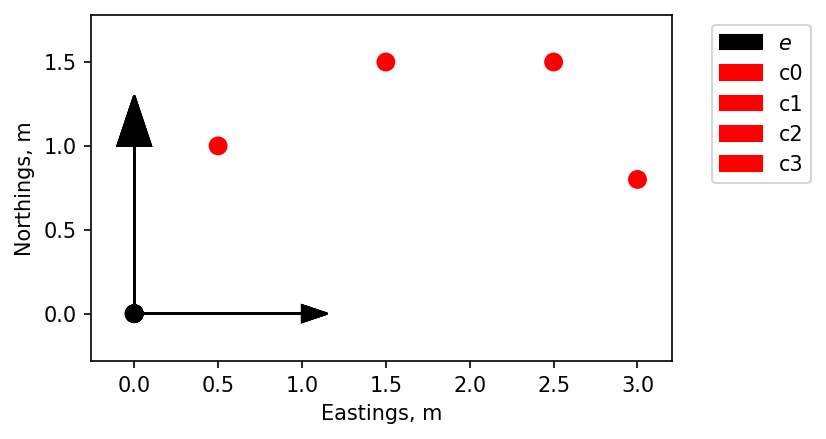

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from math_feeg6043 import v2t,t2v,l2m,HomogeneousTransformation,Inverse
from plot_feeg6043 import plot_2dframe, plot_path

# The lines above import classes and functions we will use from generic and course libraries

# Define a list of path coordinates
x_list = [1,1.5,1.5,0.8]
y_list = [0.5,1.5,2.5,3.0]

# create a matrix to store the path of coordinates
C = l2m([x_list,y_list])
print('Point path C =\n', C)
print('has dimensions ', C.shape)
print('************************************')    

# we can print the coordinates in a loop to verify they are as expected goes through each line and goes through northings and eastings
for i in range(len(C)):
    print('Point path entry c',i,': N_e=',C[i,0],'m, E_e=',C[i,1],'m')
    # we can cycle through the entire path and plot all the points using a a for loop
    plot_2dframe(['point_only','c'+str(i)],[v2t(C[i].T)])    

plt.show()

Adding heading form a pose path. Adding time constraints forms a trajectory (see definition)

> $\mathbf{P} = \begin{bmatrix} x_0 & y_0 & \gamma_0 \\
x_1 & y_1 & \gamma_1 \\
\vdots & \vdots & \vdots \\
x_n & y_n & \gamma_n\end{bmatrix} \hspace{0.5cm} \text{is a pose path} \\
\mathbf{P}(t) = \begin{bmatrix} x(t_0) & y(t_0) & \gamma(t_0) \\
x(t_1) & y(t_1) & \gamma(t_1) \\
\vdots & \vdots & \vdots \\
x(t_n) & y(t_n) & \gamma(t_n)\end{bmatrix} \text{is a trajectory with} \begin{bmatrix} t_0\\
t_1 \\
\vdots  \\
t_n\end{bmatrix}\hspace{0.5cm} \text{makes it a trajectory} $

Pose path P =
 [[1.         0.5        0.78539816]
 [1.5        1.5        1.3962634 ]
 [1.5        2.5        2.0943951 ]
 [0.8        3.         3.14159265]]
has dimensions  (4, 3)
************************************


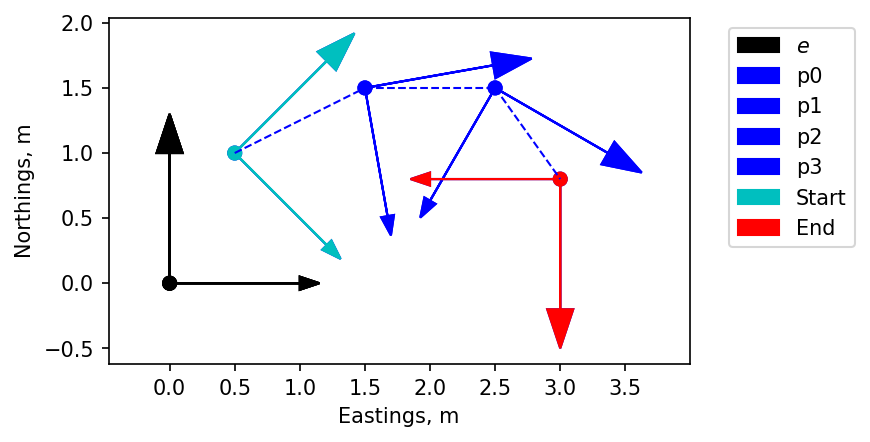

In [4]:
#first create a list of headings (we can resue our previous list of x and y coordinates) and timestamps
# note np.deg2rad([a,b]) converts the list to an array, so we need to convert back to a list....
gamma_list = np.deg2rad([45,80,120,180]).tolist()

#create a containor for our poses
P = l2m([x_list,y_list,gamma_list])
print('Pose path P =\n', P)
print('has dimensions ', P.shape)
print('************************************')    

# this does exactly the same as the plot in the previous cell but for paths
plot_path(P)

We now create some timestamps and turn this path into a trajectory.

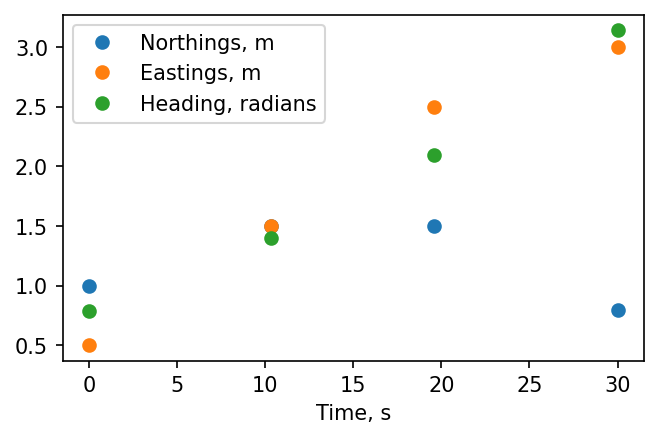

In [5]:
# make a list of timestamps
T_list = [0,10.3,19.6,30]

# Convert to a vector to associated with each pose
T = l2m(T_list)
    
# plot Trajectory at different times just plotting plot P and plot T together
plt.plot(T,P,'o',label=['Northings, m','Eastings, m','Heading, radians'])
plt.xlabel('Time, s')
plt.legend(); plt.show()

### <span style="color:red">Sampling via interpolation</span> 

Sensor timestamps are often asynchronous, control commands can interrupt regular timesteps (e.g., emergency brake), there are many situations when you need to sample data or trajectories to an arbitrary timestamp and your chances of it exactly coinciding with entries of a discrete list are small. Interpolation and extrapolation is needed (see A1.2):

\begin{equation}
z=z_{0}+(t-t_{0})\dfrac{z_{1}-z_{0}}{t_{1}-t_{0}}\notag
\end{equation}

where 
- $z=$	unknown value we want to estimate
- $t=$	known value corresponding to $z$
- $t_0, z_0	=$  known values of a function at one point 
- $t_1, z_1	=$	known values of a function at another point

In [7]:
# functions for interpolating and extrapolating timestamps that can deal with angle wrapping
# this function handles angle wrapping between 0 and the specified value
def short_angle(a0, a1, dt,wrap):    
    # calculate the difference between angle a1 and a0, wrapping the result to give the small angle    
    da = (a1 - a0) % wrap
    
    # scale the difference the query timestamp via dt 
    return a0 + (2*da % wrap - da)*dt

    # t_query = t 
def interpolate(t_query, t_lower, t_upper, x_lower, x_upper, wrap = None):
    # This function linearly interpolates or extrapolates a parameter (x) to some query timestamp
    # for periodic values like angles, the wrap value can be specified to address numerical discontinuity 
    # and keep output between [0:wrap]
        
    # handles the case where the input times to interpolate or extrapolate are the same (zero order)
    if t_upper == t_lower:
        x_query = x_lower
        
    else:
        if wrap == None:
        # id no periodic wrap value is specified, implements normal linear interpolation             
            x_query = (x_upper-x_lower)/(t_upper-t_lower)*(t_query-t_lower)+x_lower
        else: 
        # if a wrap value is specified, implements normal linear interpolation
            dt = (t_query-t_lower)/(t_upper-t_lower)
            x_query = short_angle(x_lower, x_upper, dt ,wrap) % wrap
    return x_query

# use example
print(interpolate(0.5, 0, 1, 0, 800))
print(interpolate(0.5, 0, 1, 0, 800, 360)) # for an angle we are wrapping around...360
400-360

400.0
40.0


40

Sanity check the functions, where we have values of $t=[0,1]$ where $\gamma=[355,5]$degrees. What do we expect at query t=[0.5,1.5]?

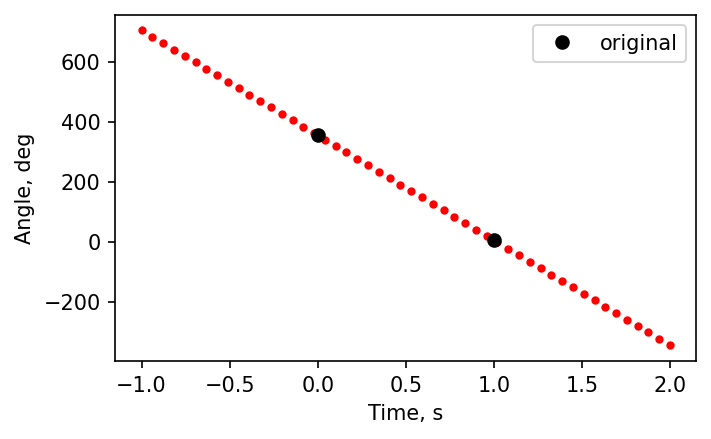

Fine for velocity, distance, but not angles


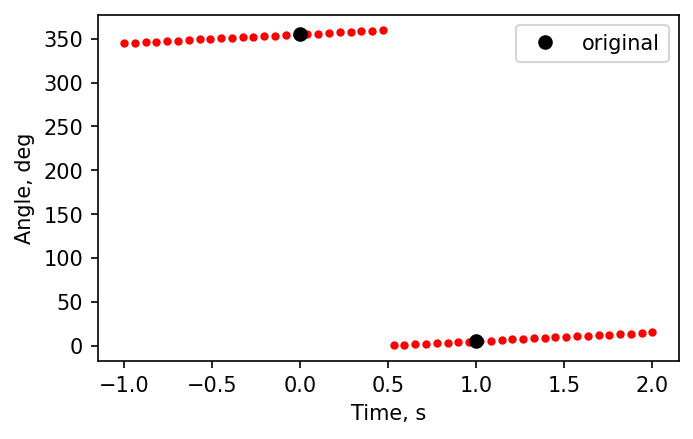

Accounts for periodic limits of angles


In [10]:
t=[0,1]
gamma=np.deg2rad([355,5])

for t_sample in np.linspace(-1,2):
    plt.plot(t_sample, np.rad2deg(interpolate(t_sample, t[0], t[1], gamma[0], gamma[1])),'r.')
plt.plot(t, np.rad2deg(gamma),'ko',label = 'original')   
plt.legend(); plt.xlabel('Time, s'); plt.ylabel('Angle, deg'); plt.show()
print('Fine for velocity, distance, but not angles')

angle_wrap = np.deg2rad(360)
for t_sample in np.linspace(-1,2):
    plt.plot(t_sample, np.rad2deg(interpolate(t_sample, t[0], t[1], gamma[0], gamma[1],angle_wrap)),'r.')
plt.plot(t, np.rad2deg(gamma),'ko',label = 'original')   
plt.legend(); plt.xlabel('Time, s'); plt.ylabel('Angle, deg'); plt.show()
print('Accounts for periodic limits of angles')

If we have asyncronous sensor data streams (e.g., IMU for $\gamma$ and GPS for $x,y$) and no model, we can generate trajectories through interlopation and extrapolation:

$ t_\gamma = [0,3.1,6.5,9.2,11.7,16.4,19.0,21.9,24.2,27.3]$\
$\gamma = [45,55.5,67.1,76.3,86.0,106.3,106.2,117.4,133.3,146.5]$

and

$ t_{xy} = [0,10.3,19.6,30]$\
$x = [1.0,1.5,1.5,0.8]$\
$y = [0.5,1.5,2.5,3.0]$

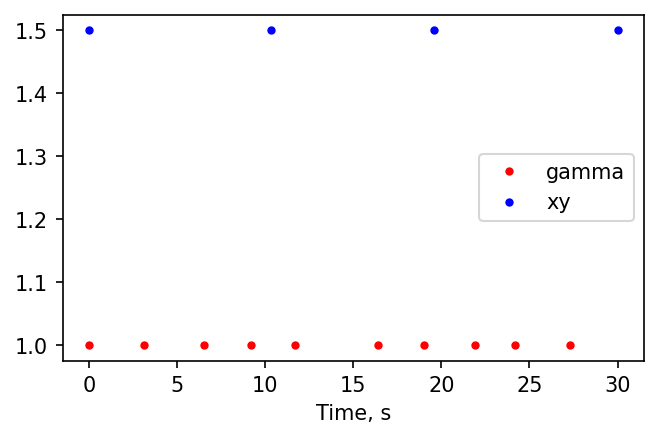

In [11]:
# create some fake sensor readings  ----next example----
T_g_list = [0,3.1,6.5,9.2,11.7,16.4,19.0,21.9,24.2,27.3]
g_list = np.deg2rad([45,55.5,67.1,76.3,86.0,106.3,106.2,117.4,133.3,146.5]).tolist()

x_list = [1.0,1.5,1.5,0.8]
y_list = [0.5,1.5,2.5,3.0]
T_xy_list = [0,10.3,19.6,30]

#create our matrices
C_xy = l2m([x_list,y_list])
T_xy = l2m(T_xy_list)
C_g = l2m([g_list])
T_g = l2m(T_g_list)

# First we plot just the timestamps ignoring parameter values
plt.plot(T_g,np.ones([len(T_g),1]),'r.',label='gamma')
plt.plot(T_xy,1.5*np.ones([len(T_xy),1]),'b.',label='xy')
plt.xlabel('Time, s'); plt.legend(); plt.show()

### <span style="color:red">Offline interpolation</span> 

Actual data points are valuable, so we should use these where possible. One way to achieve this and still get information synced is to compute equivalent time values for sensors that didn't make measurements to coincide with the timestamps of sensors that did. 

In post processing this can be done easily (e.g., you are analysing a mission offline after it has happened).

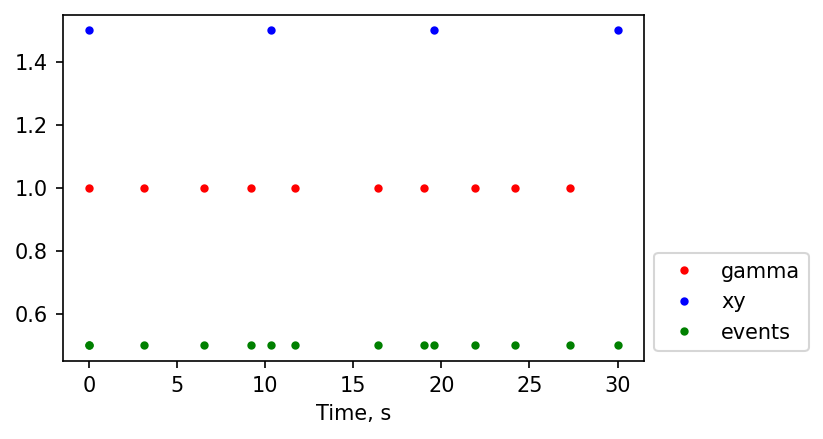

In [12]:
# combine timestamps and sort
T_p = np.concatenate((T_g, T_xy))
sorted_indices = np.argsort(T_p[:,0])
T_p = T_p[sorted_indices]

# First we plot just the timestamps ignoring parameter values
plt.plot(T_g,np.ones([len(T_g),1]),'r.',label='gamma')
plt.plot(T_xy,1.5*np.ones([len(T_xy),1]),'b.',label='xy')
plt.plot(T_p,0.5*np.ones([len(T_p),1]),'g.',label='events')
plt.xlabel('Time, s')
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))  # Move legend outside
plt.show()

A problem is we can still have gaps in our timestamps that can be a problem, e.g.,:

> last known velocity was 0.1m/s, we know the robot position will change regardless of whether we get sensor measurements or control. We need to keep track of this incase the robot is about to collide or overun a waypoint.

One way to address this is to split long intervals until we satisfy the condition that no intervals are longer than an allowable value, e.g., 
$$\Delta t_{max} =3 $$

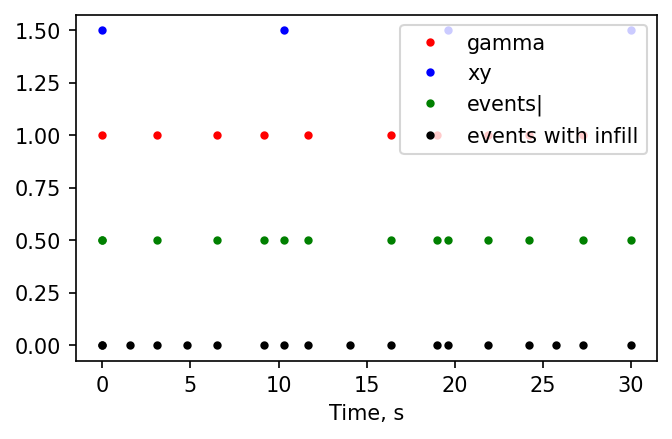

In [13]:
def fill_timegaps(dt_max,T):
    add_timestamp = []
    t_prev=T[0]
    
    #everytime the timegap is big, halve it ----adding time stamps for better//clearer data ------
    for i in range(len(T)):
        if T[i]-t_prev >= dt_max:
            add_timestamp.append(0.5*(T[i]-t_prev)+t_prev)
        t_prev = T[i]
        
    if add_timestamp != []:    
        #add those new timestamps and put in chronological order
        T = np.concatenate((T, add_timestamp))
        sorted_indices = np.argsort(T[:,0])
        T=T[sorted_indices]    
    return T

# First we plot just the timestamps ignoring parameter values
plt.plot(T_g,np.ones([len(T_g),1]),'r.',label='gamma')
plt.plot(T_xy,1.5*np.ones([len(T_xy),1]),'b.',label='xy')
plt.plot(T_p,0.5*np.ones([len(T_p),1]),'g.',label='events|')

# set max time interval and loop the gap fill until all timesteps are less that dt_max
dt_max = 3
T_prev = 0

while np.array_equal(T_p,T_prev) == False:
    T_prev = T_p
    T_p = fill_timegaps(dt_max,T_p)
    
plt.plot(T_p,0*np.ones([len(T_p),1]),'k.',label='events with infill')
plt.xlabel('Time, s'); plt.legend();plt.show()

Now we have our timestamps, we need to identify which pair of timestamps we should use to interpolate between for our different datastreams. We define a function to do this as we'll need to do it a tonne of times.

In [14]:
def id_interpolate_pair(t,T):
    # finds the location of a pair of timestamps in T that should be used for interpolation to t ---want to use timestamp which is bigger than it---
    # find the closest timestamp for gamma
    idx = (np.argmin(abs(T-t)))

    # if the closest timestamp is <t, the next timestamp must be the closest after t
    if T[idx]<=t:
        id0 = idx
        if id0 == len(T)-1: id0 = idx -1 # unless we are at the end of the data, in which case we use our previous pair and forward extrapolate        
            
    # if the closest timestamp is >t, the previous timestamp must be the closest betfore t
    else:
        id0 = idx-1
            
    return id0, id0+1    

t=7
id0,id1 = id_interpolate_pair(t,T_xy)
print('The pair to interpolate in T_xy\n',T_xy,' for a time query of ',t,'s, is', T_xy[id0],T_xy[id1],'s')
id0,id1 = id_interpolate_pair(t,T_g)
print('The pair to interpolate in T_g\n',T_g,' for a time query of ',t,'s, is', T_g[id0],T_g[id1],'s')

The pair to interpolate in T_xy
 [[ 0. ]
 [10.3]
 [19.6]
 [30. ]]  for a time query of  7 s, is [0.] [10.3] s
The pair to interpolate in T_g
 [[ 0. ]
 [ 3.1]
 [ 6.5]
 [ 9.2]
 [11.7]
 [16.4]
 [19. ]
 [21.9]
 [24.2]
 [27.3]]  for a time query of  7 s, is [6.5] [9.2] s


We can now compute interpolated poses at all the timestamps


************************************************
Timestamps (s)
 [[ 0.  ]
 [ 0.  ]
 [ 1.55]
 [ 3.1 ]
 [ 4.8 ]
 [ 6.5 ]
 [ 9.2 ]
 [10.3 ]
 [11.7 ]
 [14.05]
 [16.4 ]
 [19.  ]
 [19.6 ]
 [21.9 ]
 [24.2 ]
 [25.75]
 [27.3 ]
 [30.  ]] 
Pose trajectory [x,y,gamma]
 [[1.         0.5        0.78539816]
 [1.         0.5        0.78539816]
 [1.07524272 0.65048544 0.87702795]
 [1.15048544 0.80097087 0.96865773]
 [1.23300971 0.96601942 1.06988683]
 [1.31553398 1.13106796 1.17111593]
 [1.44660194 1.39320388 1.33168622]
 [1.5        1.5        1.40617687]
 [1.5        1.65053763 1.50098316]
 [1.5        1.90322581 1.67813408]
 [1.5        2.15591398 1.85528499]
 [1.5        2.43548387 1.85353967]
 [1.5        2.5        1.89398316]
 [1.34519231 2.61057692 2.04901654]
 [1.19038462 2.72115385 2.32652389]
 [1.08605769 2.79567308 2.44171562]
 [0.98173077 2.87019231 2.55690735]
 [0.8        3.         2.75756392]]
************************************************



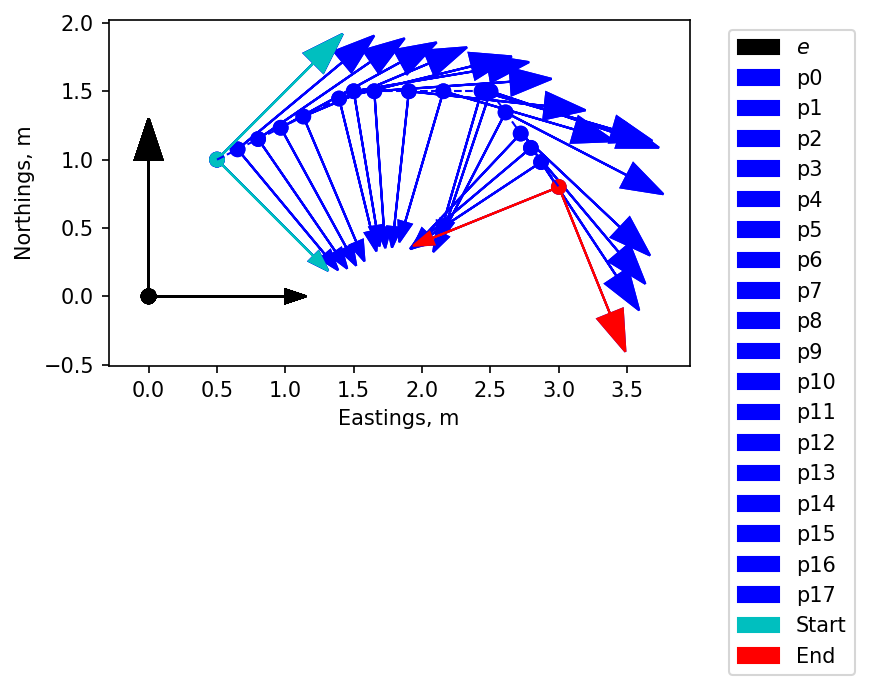

In [17]:
from math_feeg6043 import fill_timegaps, id_interpolate_pair, Vector, Matrix

# containor for trajectory, TP is for timestamps, P is for event driven sync ---want to use timestamp which is bigger than it---
P = Matrix(0,3)
# containor for current xy or gamma and pose
p = Vector(3)

# cycle through the sorted events 
for t in T_p:
    
    # finds the pair in each datastream to interpolate between
    id_g0,id_g1 = id_interpolate_pair(t,T_g)
    id_xy0,id_xy1 = id_interpolate_pair(t,T_xy)    
                 
    # interpolating angles, needs to wrap at np.deg2rad(360)
    gp = interpolate(t, T_g[id_g0], T_g[id_g1], C_g[id_g0], C_g[id_g1], wrap = np.deg2rad(360))
    
    # interpolating x, y, no need to wrap ---t = time stamp//T_xy[id_xy0] = 
    xp = interpolate(t,T_xy[id_xy0], T_xy[id_xy1], C_xy[id_xy0].T[0], C_xy[id_xy1].T[0])   
    yp = interpolate(t, T_xy[id_xy0], T_xy[id_xy1], C_xy[id_xy0].T[1], C_xy[id_xy1].T[1])   

    # construct  latest pose with all values representing same moment in time ---
    p[0] = xp; p[1] = yp; p[2] = gp
    
    # append transposed pose trajectory matrix with event driven interpolation
    P = np.vstack((P, p.T))
        
print('\n************************************************')        
print('Timestamps (s)\n', T_p, '\nPose trajectory [x,y,gamma]\n',P)
print('************************************************\n')     
plot_path(P)

## <span style="color:green">2. Motion modelling</span>

### <span style="color:green">Rigid body kinematics</span>
We will develop a rigid body kinematic motion model that satisfies the form $\mathbf{p}_{k} = g(\mathbf{p}_{k-1},\mathbf{u}_{k})$ using homogeneous matrices and verify its function. 

\begin{eqnarray}
&\mathbf{X}_{k}& = &\hspace{0.8cm}\mathbf{X}_{k-1}\hspace{0.6cm}\text{Trans}(\mathbf{t}_{bc})\hspace{0.2cm}\text{Rot}(\omega_k \Delta t_k) \hspace{0.2cm}\text{Trans}(\mathbf{t}_{cb'})&\notag\\
&\begin{bmatrix}
 \mathbf{R}_{eb'} & \mathbf{t}_{eb'}\\ 0 & 1 \end{bmatrix} \hspace{0.5cm}&= \hspace{0.5cm} &\begin{bmatrix}
  \mathbf{R}_{eb} & \mathbf{t}_{eb}\\ 0 & 1 \end{bmatrix} \begin{bmatrix}
\mathbf{I} & \mathbf{t}_{bc}\\ 0 & 1 \end{bmatrix} \begin{bmatrix}
  \mathbf{R}_{cb'} & 0\\ 0 & 1 \end{bmatrix} \begin{bmatrix}
\mathbf{I} & \mathbf{t}_{cb'}\\ 0 & 1 \end{bmatrix} \notag
\end{eqnarray}    

In [19]:
def rigid_body_kinematics(mu,u,dt=0.1):
    ################################################################################# ---- C is the point of ROTATION----
    # This function models the forwards kinematics of rigid body, b
    # It implements a model of form
    #  mu_k = f(mu_k-1,u_k)
    # and progresses the pose of the robot 'mu' (in the fixed frame e)) 
    # to the next timestep 'mu_' by applying combined linear and angular velocity (twist) 
    # as its control action 'u' for the period 'dt'. 
    #
    # The notation of 'mu' is used as it represents the mean estimate of the robot pose p
    #
    # It implements the homogeneous transformation below to achieve this.
    # 
    # Xk = Xk-1 Trans(tbc)Rot(wdt)Trans(tcb')
    #
    # as 
    #
    # H_eb' = H_eb @ H_bc.H_T @ H_cb'.H_R @ H_cb'.H_T
    #
    # Inputs
    #.  mu: The previous pose p_{k-1}, which is a [3x1] matrix of form
    #          [[x]     Northings in m (fixed frame, e )
    #           [y]     Eastings in m (fixed frame, e )
    #           [g]]    Heading in rads (fixed frame, e )
    #.  u:  The control is a [2 x 1] matrix of the form, 
    #         [[v]      Linear forwards velocity in m/s (body frame, b)
    #.         [w]]     Angular velocity in rads/s (body frame, b)
    # Output
    #.  mu: The new pose p_k
    #
    # Dependancies 
    #.  standard python libraries (numpy)
    #.  class HomogeneousTransformation from course library `math_feeg6043.py`
    #################################################################################    
 
    # create an empty containors for the output and its homogeneous representation
    mu_=Vector(3)
    H_eb_ = HomogeneousTransformation()
    
    # convert input pose p_k-1 into a homogeneous transformation matrix 
    t_eb=Vector(2)
    t_eb[0] = mu[0] # northings (p_k-1)
    t_eb[1] = mu[1] #eastings (p_k-1)
    g_eb = mu[2] #heading (p_k-1)
    H_eb = HomogeneousTransformation(t_eb,g_eb)            

    # handles the stationary case where 
    if u[0]==0 and u[1]==0:        
        H_eb_ = H_eb 

    # if the robot is going in a straight line
    elif u[1]==0:        
        # implement a simpler vesion of the model that doesn't need to compute twist 
        # H_eb_ = H_eb@H_bb' 

        v = u[0] #surge rate        
            
        # compute motion in the body frame due to the pure linear velocity
        t_bb_=Vector(2) # [2x1] matrix of 0
        t_bb_[0] = v*dt
        
        # create the homogeneous transformation from b to b', 
        H_bb_ = HomogeneousTransformation(t_bb_,0) # heading doesn't change as w=0 (u[1]=0]
        
        # left multiply be the homogeneous transformation from the fixed frame e to the body frame b
        H_eb_.H = H_eb.H@ H_bb_.H
            
    else: 
        # implements the model derived for twist
        v = u[0] #surge rate
        w = u[1] #yaw rate

        # calculate centre of rotation from the initial body position
        t_bc = Vector(2) # [2x1] matrix of 0                       
        t_bc[1]=v/w      # centre of rotation is ?
        
        # the centre of rotation 'c' keeps the heading of the body, so is 0 as seen from the body
        H_bc = HomogeneousTransformation(t_bc,0)
            
        # to rotate the body about 'c' so need 'b' as seen from the centre of rotation
        H_cb = HomogeneousTransformation() 
        H_cb.H = Inverse(H_bc.H)

        # to rotate the body b around the centre of rotation w*dt while maintain the same radius
        H_cb_ = HomogeneousTransformation(H_cb.t,w*dt)
        
        # we rotate first, and then translate
        H_eb_.H = H_eb.H@H_bc.H@H_cb_.H_R@H_cb_.H_T
        
    # create the pose, handling angle wrap at 2pi (in rads)
    mu_[0] = H_eb_.t[0]
    mu_[1] = H_eb_.t[1]
    mu_[2] = H_eb_.gamma % (2 * np.pi )
    
    return mu_

Sanity check the model outputs by trying different input poses and controls and checking the results make sense. Try running these 60s calclations for different control inputs:
$$\mathbf{u}=\begin{bmatrix}0.2\\0\end{bmatrix}, \hspace{0.5cm}\mathbf{u}=\begin{bmatrix}-0.2\\0\end{bmatrix}, \hspace{0.5cm}\mathbf{u}=\begin{bmatrix}0.2\\6\end{bmatrix}, \hspace{0.5cm}\mathbf{u}=\begin{bmatrix}0.5\\6\end{bmatrix}$$

*make sure angular rates are converted to SI units*

In [21]:
# Test it works define an initial pose
p = Vector(3)
p[0] = 0 # x in frame e
p[1] = 0 # y in frame e
p[2] = np.deg2rad(0) # gamma in frame e

u = Vector(2)
u[0] = -0.2 # m/s forwards in frame b
u[1] = 0 # rad/s heading change in frame b
# provide a timestep
dt = 60

# apply the model and check outputs make sense
p_ = rigid_body_kinematics(p,u,dt)

print('Initial pose [x,y] = [',p[0],p[1],']m, \u03B3_eb =',np.rad2deg(p[2]),'deg in frame e')# \u03B3 is unicode for greek gamma
print('Body twist control [v,\u03C9] = [',u[0],np.rad2deg(u[1]),'] (m/s, deg/s) applied for ',dt,'s in frame b')# \u03C9 is unicode for greek gamma
print('Final pose [x,y] = [',p_[0],p_[1],']m, \u03B3_eb =',np.rad2deg(p_[2]),'deg in frame e')# \u03B3 is unicode for greek gamma

Initial pose [x,y] = [ [0.] [0.] ]m, γ_eb = [0.] deg in frame e
Body twist control [v,ω] = [ [-0.2] [0.] ] (m/s, deg/s) applied for  60 s in frame b
Final pose [x,y] = [ [-12.] [0.] ]m, γ_eb = [0.] deg in frame e


Next we can plot some simple trajectories using the motion model to progress the state to specified timestamps (e.g., these might be timestamps there we get position sensor measurements that we want to compare):

> $$ \mathbf{T}_p= [0,5,10,15,20,25,30,35,40,45,50,55,59]^T$$

We can do this for different control input scenarios:

>$$\mathbf{u}=\begin{bmatrix}0.2\\0\end{bmatrix}, \hspace{0.5cm}\mathbf{u}=\begin{bmatrix}-0.2\\0\end{bmatrix}, \hspace{0.5cm}\mathbf{u}=\begin{bmatrix}0.2\\6\end{bmatrix}\hspace{0.5cm}\mathbf{u}=\begin{bmatrix}0.5\\6\end{bmatrix}$$

We can do this for a initial pose of

> $$\mathbf{p} = [1.38,-1.38,45]^T$$

*make sure angles and angular rates are converted to SI units*

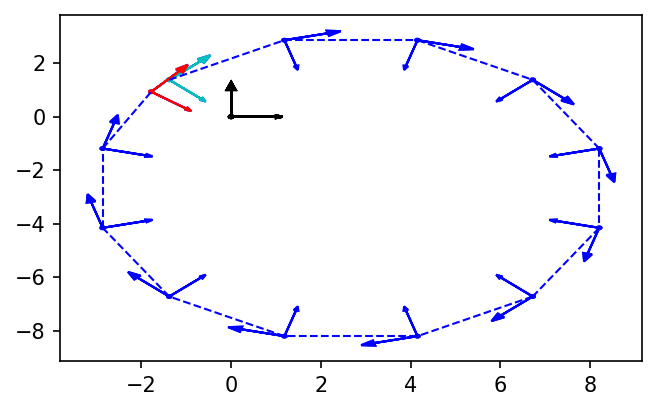

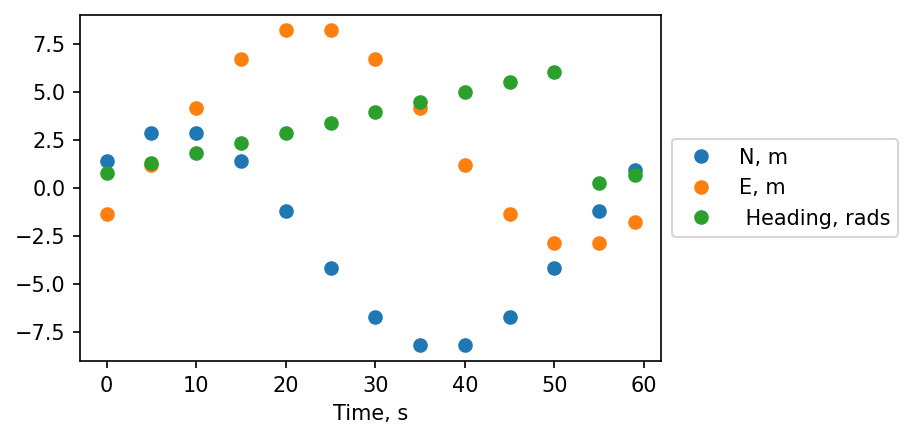

In [29]:
# define an initial pose - can use same values as earlier
p = Vector(3)
p[0] = 1.38
p[1] = -1.38
p[2] = np.deg2rad(45)

# create the control as a twist vector, where motion model assumes
v = 0.6 # m/s forwards in the body frame
w = np.deg2rad(6)

u = Vector(2)
u[0] = v #motion model assumes 
u[1] = w

# create some timestamps we want to model motion to and visualise
t_list = [0,5,10,15,20,25,30,35,40,45,50,55,59]
t_prev=0

# create containors for pose results 
T_p = l2m(t_list)
P = Matrix(0,3)

# simulation for loop
for i in range(len(T_p)):
    # get next timestamp to model motion to (likely some event)
    t=T_p[i]

    # determine time interval
    dt = t-t_prev

    # apply the model
    p = rigid_body_kinematics(p,u,dt) # previous pose, control, time interval
     
    # store trajectory
    P = np.vstack((P, p.T))
    
    # store timestamp to calculate dt
    t_prev = t
    
# plot the path
plot_path(P,legend_flag = False)
plt.show()

# plot trajectory time history
plt.plot(T_p,P,'o',label=['N, m','E, m',' Heading, rads'])
plt.xlabel('Time, s')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Normally, robots will change their control inputs. What do you expect the path will look like resulting from this control sequence?

> v_list = [0.2, 0.1, 0.2, 0, 0.1,0] # m/s forwards in the body frame
>
> w_list = np.deg2rad([9, -6, 0, -9, 0,0])
>
> t_list = [0,20,50,60,70,100] # times from where the control applies

Sketch it out by hand first to know what to expect. Plot the model outputs at a minimum interval of 3s, but making sure that control input change events are also modelled.

First plot the control commands using the function `plot_zero_order`, which just illustrates constant commands between updates.

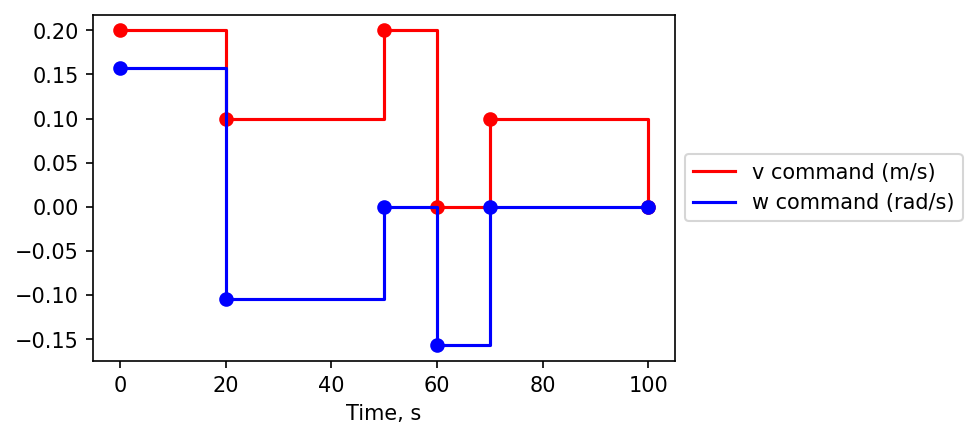

In [30]:
from plot_feeg6043 import plot_zero_order

# create a list of twist actions at different timestamps
v_list = [0.2, 0.1, 0.2, 0, 0.1,0] # m/s along x-axis in the body frame
w_list = np.deg2rad([9, -6, 0, -9, 0,0]).tolist() # rad/s in the body frame
t_list = [0,20,50,60,70,100] # times from where the control applies

plot_zero_order(t_list,v_list, 'r', label = 'v command (m/s)')
plot_zero_order(t_list,w_list, 'b', label = 'w command (rad/s)')
plt.show()

Now provide these commands to the motion model

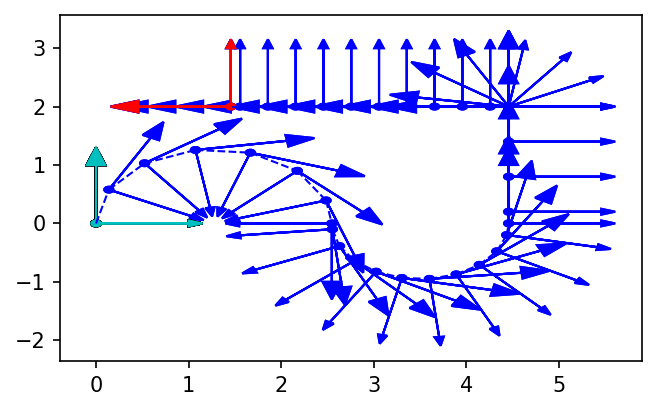

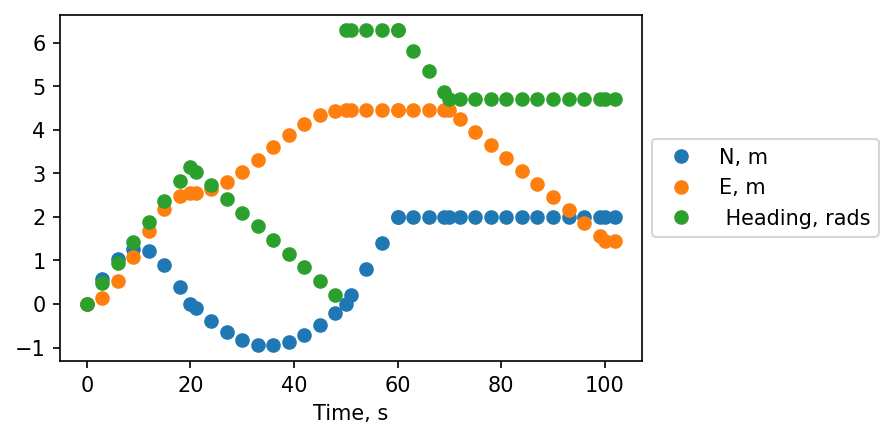

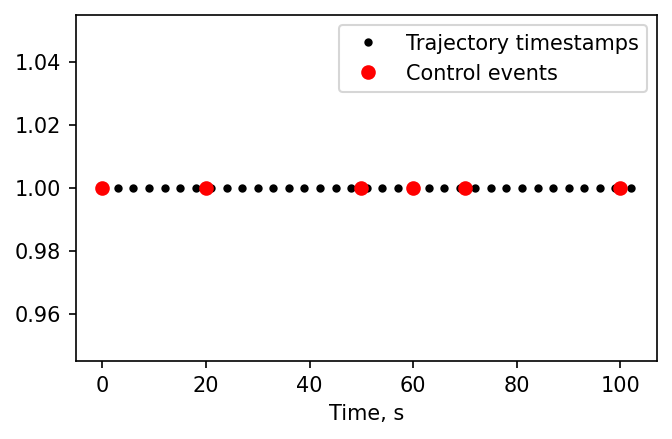

In [31]:
import copy
# create an initial pose starting from the same position as before
p = Vector(3)

# create the control with corresponding timestamps
T_u = l2m(t_list) 
U =  l2m([v_list,w_list]) 
# containor for current controls
u=Vector(2)

# counter to point to the next control timestep, flag to show an event just happend
idx = 0

# create some timestamps we want to model motion to and visualise
t=copy.copy(T_u[0])
t_int = 3

# create containors for results 
T_p = Vector(0)
P = Matrix(0,3)

# simulation in a while loop
while t <T_u[-1]+1:

#     print('t = ', t,'s')    
        
    # if the next control event is less than the minimum timestep
    # model progressed to the control timestep and update the control values
    if T_u[idx] - t < t_int:
#         print('Control event',idx)
        
        # use this times stamp to calculate dt
        dt= T_u[idx] - t                
        
        # apply the model with to progress to dt with old control values
        p = rigid_body_kinematics(p,u,dt) 
#         print('v =',u[0],'m/s, w = ',u[1],'rad/s to ',T_u[idx],'s')  
              
        # apply next control after progressing to dt 
        # unless this was the first control, when the initial value applies
        # or the last control, where the last value should still apply
        if idx != len(t_list): idx += 1
        
        # Store the trajectory upto the next control and pose
        T_p = np.vstack((T_p, t+dt))
        P = np.vstack((P, p.T))        
    
    # otherwise set the event dt to 0
    else: dt = 0
    
    # progress to the prescribed timestep, interval needs reducing when there has been a control event
    dt = t_int - dt
    t += t_int # progress the timestep
       
    # read current control values up to the next control event
    if idx == 0:
        u[0] = 0
        u[1] = 0
    else:
        u[0] = U[idx-1,0]
        u[1] = U[idx-1,1]

    # apply control ot to the next timestep
    p = rigid_body_kinematics(p,u,dt) 
#     print('v =',u[0],'m/s, w = ',u[1],'rad/s to ',t,'s')
    
    # store trajectory
    T_p = np.vstack((T_p,t))
    P = np.vstack((P,p.T))
    
# plot the path
plot_path(P, legend_flag = False, verbose = False)
plt.show()

# plot trajectory time history
plt.plot(T_p,P,'o',label=['N, m','E, m',' Heading, rads'])
plt.xlabel('Time, s')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# plot just the timesteps to veryify expected behaviour
plt.plot(T_p,np.ones([len(T_p),1]),'k.',label='Trajectory timestamps')
plt.plot(T_u,np.ones([len(T_u),1]),'ro',label='Control events')
plt.xlabel('Time, s')
plt.legend()
plt.show()

### <span style="color:green">Actuator configuration</span>

We develop a class to handle differential drive kinematics

**Forward kinamatics:**
\begin{eqnarray} 
\begin{bmatrix}v \\ \omega\end{bmatrix} = G\begin{bmatrix} \omega_r \\ \omega_l \end{bmatrix},\hspace{1cm}\text{where}\hspace{1cm}G = \begin{bmatrix} \dfrac{d}{4} & \dfrac{d}{4}  \\ -\dfrac{d}{2W} & \dfrac{d}{2W}\end{bmatrix}
\end{eqnarray}    

**Inverse kinematics:**
\begin{eqnarray}    
 \begin{bmatrix} \omega_r \\ \omega_l \end{bmatrix} =  G^{-1}\begin{bmatrix}v \\ \omega\end{bmatrix},\hspace{1cm}\text{where}\hspace{1cm}G^{-1}  =  \begin{bmatrix} \dfrac{2}{d} & -\dfrac{W}{d}  \\\dfrac{2}{d} & \dfrac{W}{d} \end{bmatrix}\notag
\end{eqnarray}  

In [33]:
class actuator_configuration_model:

    """
    Class to model kinematics of a 2 wheel differential drive
    Assumes symmetry about the vehicle centre line and the 
    body frame origin coincides with the centre of rotation
    
    Parameters:
    -----------
    W: float
        Perpendicular distance of each wheel to robot's x-axis centre line in metres
    d: float
        Diametre of each wheel in metres

    Attributes:
    -----------
    G: Matrix(2,2)
        Actuator configuration matrix [d/4 d/4; -d/2W d/W] 
    invG: Matrix(2,2)
        Inverse of actuator configuration matrix [2/d -W/d; 2/d W/d]     
        
    Functions:
    -----------
    inv_kinematics(self, u):
        Models the actuator inverse kinematics and computes wheel 
        commands to achieve desired rigid body twist 

        Input:
            u:  Body twist is a [2 x 1] matrix of the form
                  [[v]      Linear forwards velocity in m/s (body frame, b)
                   [w]]     Angular velocity in rads/s (body frame, b)
        Output:
            q: The wheel rates of each wheel in rad/s, of the form
               [[w_r]    wheel aligned with +ve y-axis of robot
                [w_l]]   wheel aligned with -ve y-axis of robot   

    fwd_kinematics(self, u): 
        Models the actuator kinematics and computes rigid body twist corresponding 
        to provided wheel commands      
        
        Input:
            q: The wheel rates of each wheel in rad/s, of the form
               [[w_r]    wheel aligned with +ve y-axis of robot
                [w_l]]   wheel aligned with -ve y-axis of robot   

        Output:
            u:  Body twist is a [2 x 1] matrix of the form 
                  [[v]      Linear forwards velocity in m/s (body frame, b)
                   [w]]     Angular velocity in rads/s (body frame, b)

    """    
    
    def __init__(self, W, d):
        
        self.W = W
        self.d = d
        self.G = Matrix(2,2)
        self.invG = Matrix(2,2)
        
        self.G[0,0] = d/4
        self.G[0,1] = d/4
        self.G[1,0] = -d/(2*W)
        self.G[1,1] = d/(2*W)
        
        self.invG[0,0] = 2/d
        self.invG[0,1] = -W/d                
        self.invG[1,0] = 2/d        
        self.invG[1,1] = W/d                        
    
    def inv_kinematics(self, u): q = self.invG @ u; return q
    def fwd_kinematics(self, q): u = self.G@q; return u    

- Pick sensible values of wheel diameter and seperation and sanity check R matrices and invR matrices make sense

In [34]:
W = 0.075 #m wheel seperation to centreline
d = 0.08 #m wheel diameter

# create an instance of the class with these variables
ddrive = actuator_configuration_model(W, d)

# does the G configuration matrix make sense?
print('G =\n',ddrive.G)

# does the inverse make sense?
print('G^{-1} =\n',ddrive.invG)
print('*****************************************')

# do wheel speeds make sense
u = Vector(2)
u[0] = 0.1 #m/s
u[1] = 0 #rad/s

# inverse kinematics converts twists to wheel commands
q = ddrive.inv_kinematics(u)

print('For v = ',u[0],'m/s, w = ',u[1],'rad/s')
print('need w_r = ',q[0],'rad/s, w_l = ',q[1],'rad/s')

#print('***************!!!!!1Different set ups!!!!!**************************')
#u[0] = 0 #m/s
#u[1] = 0.1 #rad/s

#q = ddrive.inv_kinematics(u)
#print('For v = ',u[0],'m/s, w = ',u[1],'rad/s')
#print('need w_r = ',q[0],'rad/s, w_l = ',q[1],'rad/s')

#u[0] = 0.1 #m/s
#u[1] = 0.1 #rad/s

print('*****************************************')
q = ddrive.inv_kinematics(u)
print('For v = ',u[0],'m/s, w = ',u[1],'rad/s')
print('need w_r = ',q[0],'rad/s, w_l = ',q[1],'rad/s')
print('average (w_r+w_l)/2 = ',(q[0]+q[1])/2,'rad/s')
print('difference (w_l-w_r) = ',q[1]-q[0],'rad/s')

G =
 [[ 0.02        0.02      ]
 [-0.53333333  0.53333333]]
G^{-1} =
 [[25.     -0.9375]
 [25.      0.9375]]
*****************************************
For v =  [0.1] m/s, w =  [0.] rad/s
need w_r =  [2.5] rad/s, w_l =  [2.5] rad/s
*****************************************
For v =  [0.1] m/s, w =  [0.] rad/s
need w_r =  [2.5] rad/s, w_l =  [2.5] rad/s
average (w_r+w_l)/2 =  [2.5] rad/s
difference (w_l-w_r) =  [0.] rad/s


- Use inverse kinematics to compute the corresponding wheel commands for the twist commands we used in the motion model earlier.
- Reproduce results from earlier using the wheel commands, and going via the forward actuator kinematics

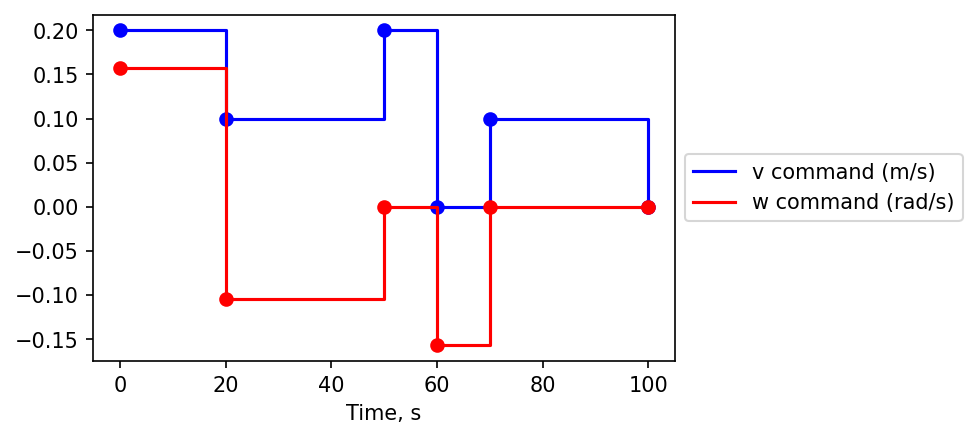

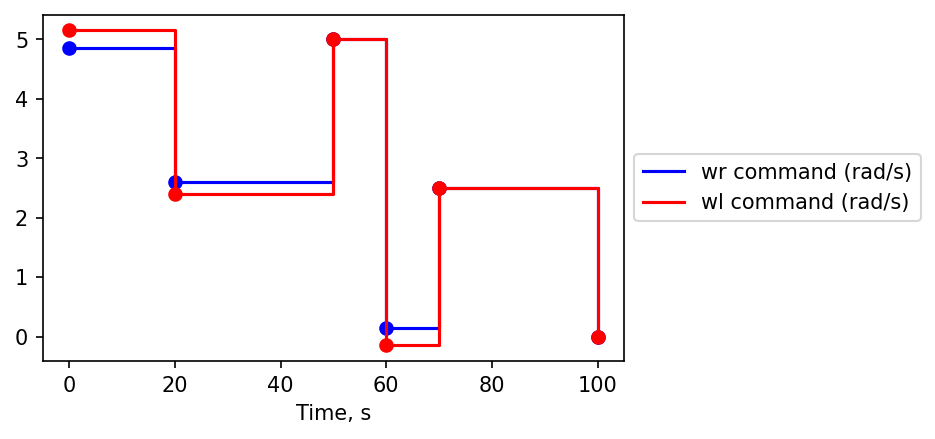

In [35]:
# plot the control commands we used earlier
plot_zero_order(T_u,U[:,[0]], 'b', label = 'v command (m/s)')    
plot_zero_order(T_u,U[:,[1]], 'r', label = 'w command (rad/s)')
plt.show()

# containor to store actuation commands
v = Vector(2)
wr_list = []
wl_list = []

for i in range(len(t_list)):
    u[0] = U[i,[0]]
    u[1] = U[i,[1]]
    
    q = ddrive.inv_kinematics(u)
    
    wr_list.append(q[0,0])
    wl_list.append(q[1,0])   
    
# visulise if they make sense
plot_zero_order(t_list,wr_list, 'b', label = 'wr command (rad/s)')    
plot_zero_order(t_list,wl_list, 'r', label = 'wl command (rad/s)')    
plt.show()

Put the commands you just generated into the actuator and rigid body forward kinematics and check you can reproduce outputs from earlier

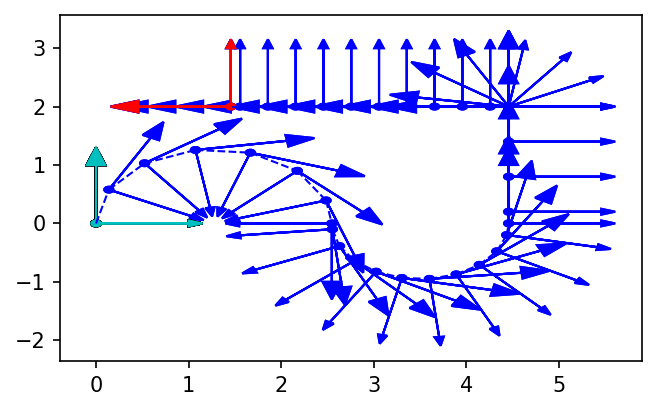

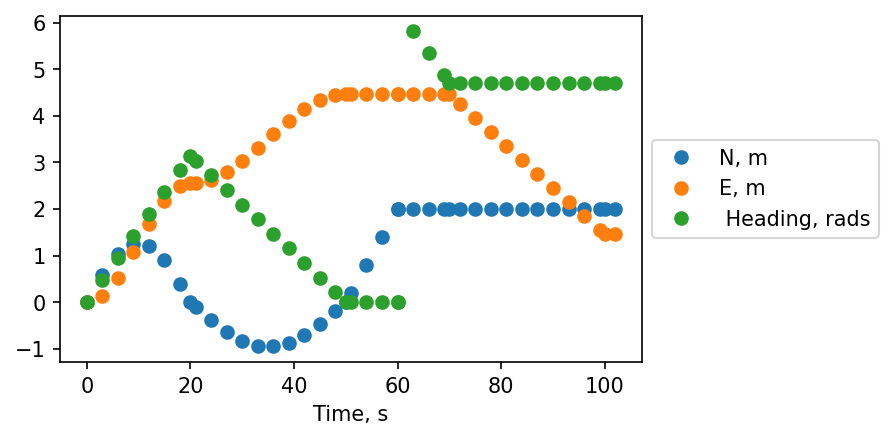

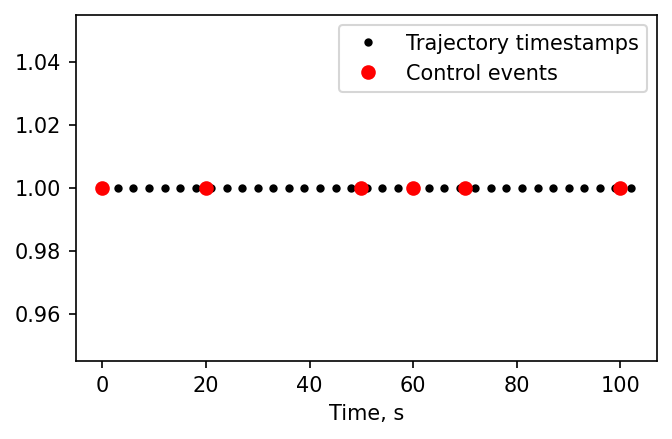

In [36]:
import copy
# create an initial pose starting from the same position as before
p = Vector(3)

# create the control with corresponding timestamps
T_u = l2m(t_list) 
U =  l2m([v_list,w_list]) 
# containor for current controls
u=Vector(2)

# counter to point to the next control timestep, flag to show an event just happend
idx = 0

# create some timestamps we want to model motion to and visualise
t=copy.copy(T_u[0])
t_int = 3

# create containors for results 
T_p = Vector(0)
P = Matrix(0,3)

# simulation in a while loop
while t <T_u[-1]+1:

#     print('t = ', t,'s')    
        
    # if the next control event is less than the minimum timestep
    # model progressed to the control timestep and update the control values
    if T_u[idx] - t < t_int:
#         print('Control event',idx)
        
        # use this times stamp to calculate dt
        dt= T_u[idx] - t       
        
        # use the forward kinamatic------s to compute twist from the wheel commands
        u = ddrive.fwd_kinematics(q)   
        
        # apply the model with to progress to dt with old control values
        p = rigid_body_kinematics(p,u,dt) 
#         print('v =',u[0],'m/s, w = ',u[1],'rad/s to ',T_u[idx],'s')  
              
        # apply next control after progressing to dt 
        # unless this was the first control, when the initial value applies
        # or the last control, where the last value should still apply
        if idx != len(t_list): idx += 1
        
        # Store the trajectory upto the next control and pose
        T_p = np.vstack((T_p, t+dt))
        P = np.vstack((P, p.T))        
    
    # otherwise set the event dt to 0
    else: dt = 0
    
    # progress to the prescribed timestep, interval needs reducing when there has been a control event
    dt = t_int - dt
    t += t_int # progress the timestep
       
    # read current control values up to the next control event
    if idx == 0:
        q[0] = 0
        q[1] = 0
    else:
        q[0] = wr_list[idx-1]
        q[1] = wl_list[idx-1]   

    # use the forward kinematics to compute twist from the wheel commands
    u = ddrive.fwd_kinematics(q)                   

    # apply control ot to the next timestep
    p = rigid_body_kinematics(p,u,dt) 
#     print('v =',u[0],'m/s, w = ',u[1],'rad/s to ',t,'s')
    
    # store trajectory
    T_p = np.vstack((T_p, t))
    P = np.vstack((P, p.T))
    
# plot the path
plot_path(P, legend_flag = False, verbose = False)
plt.show()

# plot trajectory time history
plt.plot(T_p,P,'o',label=['N, m','E, m',' Heading, rads'])
plt.xlabel('Time, s')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# plot just the timesteps to veryify expected behaviour
plt.plot(T_p,np.ones([len(T_p),1]),'k.',label='Trajectory timestamps')
plt.plot(T_u,np.ones([len(T_u),1]),'ro',label='Control events')
plt.xlabel('Time, s')
plt.legend()
plt.show()

Now repeat the same wheel rate commands but modify the actuator configuration. You can modify it below and run the cell above again. Start by:
- Make the wheel seperation 10x bigger and make sure the results make sense to you.
- See what happens if you also increase the wheel diameter by 10x. Do you get the same trajectory as the original?

In [ ]:
del(ddrive)

W = ? #m wheel seperation to centreline, originally 0.06
d = ? #m wheel diameter, originally 0.04
# create an instance of the class with these variables
ddrive = actuator_configuration_model(W, d)

Note you can always determine what wheel rates you would need to achieve the desired twist by running them through the  inverse kinematics of the new actuator configuration.
> **Original twists if you want to give it a go**
>
> v_list = [0.2, 0.1, 0.2, 0, 0.1,0] # m/s forwards in the body frame
>
> w_list = np.deg2rad([9, -6, 0, -9, 0,0])
>
> t_list = [0,20,50,60,70,100] # times from where the control applies

## <span style="color:blue">Wrap up</span>

You should now:

- Know what is meant by paths/trajectories and dynamics/kinematics and recongnise the importance of correctly dealing with timestamps in robotics. In particular, you should be able to distinguish application where dynamic modelling might be required 
- Be comfortable with the theory and implementation of a motion model using homogeneous transformation. 
- Be comfortable using forward and inverse kinamatics of a simple actuator configurations.
- Understand how to adapt these equations as necessary to describe other simple robotic configurations.